# Enhanced Tennis Shot Classifier

This notebook provides a modular and robust framework for training and evaluating tennis shot classifiers using Recurrent Neural Networks (RNNs).

### Key Improvements Over Original Notebook:
1.  **K-Fold Cross-Validation**: Implements `StratifiedKFold` for more reliable and robust model evaluation, ensuring that class distributions are preserved in each fold.
2.  **Modular Model Architecture**: A new function, `get_models()`, allows you to easily define and experiment with multiple Keras model architectures (e.g., GRU, LSTM, deeper networks) without changing the training code.
3.  **Refactored Code**: Data loading, preprocessing, and model training logic have been encapsulated into separate, clean functions for better readability and reusability.
4.  **Automated Evaluation Summary**: The script automatically runs all defined models through the K-fold process and presents a clear summary of their performance (mean accuracy and standard deviation), making it easy to compare models.
5.  **Clear Workflow**: The notebook is structured logically: Configuration -> Data Loading -> Model Definition -> K-Fold CV -> Results Summary -> Final Evaluation.

## 1. Imports and Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# --- Configuration ---
MERGE_SIMILAR_SHOTS = True
N_SPLITS = 5  # Number of folds for K-Fold Cross-Validation
EPOCHS = 100
BATCH_SIZE = 32

# --- Dataset Folders ---
TRAIN_FOLDERS = [
    "Emma Raducanu Court Level Practice 2024 (4K 60FPS)", 
    "Emma Raducanu ｜ Court Level Practice [4k 60fps]", 
    "Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice", 
    "World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)",
    "jsinner_h264",
    "jsinner2_h264"
]

TEST_FOLDERS = ["Novak Djokovic & Alexander Zverev Condensed Court Level Practice 2024 4K 60FPS"]

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-07-23 20:02:16.903746: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 20:02:16.904310: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 20:02:16.906279: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 20:02:16.911422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753281136.919905   66721 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753281136.92

TensorFlow Version: 2.19.0
Num GPUs Available:  0


2025-07-23 20:02:17.788685: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Data Loading and Preprocessing
This function handles loading data from CSVs, merging shot classes, and returning features and labels.

In [2]:
def merge_shot_classes(shot_type, merge_similar=True):
    """Merge similar shot classes if requested."""
    if not merge_similar:
        return shot_type
    shot_mappings = {'overhead': 'serve', 'smash': 'serve'}
    return shot_mappings.get(shot_type, shot_type)

def load_data_from_folders(folders, base_path="dataset/"):
    """Loads all shot data from a list of folders."""
    X, y = [], []
    for folder in folders:
        dataset_path = os.path.join(base_path, folder)
        if not os.path.exists(dataset_path):
            print(f"Warning: {dataset_path} doesn't exist, skipping...")
            continue
        
        print(f"Loading shots from {folder}")
        csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
        
        for shot_csv in tqdm(sorted(csv_files), desc=f"Processing {folder}"):
            data = pd.read_csv(os.path.join(dataset_path, shot_csv))
            name_parts = shot_csv.replace('.csv', '').split('_')
            
            # Determine shot type from filename
            if len(name_parts) >= 3 and name_parts[1] in ['volley', 'slice']:
                shot_type = f"{name_parts[0]}_{name_parts[1]}"
            else:
                shot_type = name_parts[0]
            
            shot_type = merge_shot_classes(shot_type, MERGE_SIMILAR_SHOTS)
            features = data.loc[:, data.columns != 'shot']
            X.append(features.to_numpy())
            y.append(shot_type)
            
    return np.stack(X, axis=0), np.array(y)

# Load the training and test datasets
X_train_full, y_train_full = load_data_from_folders(TRAIN_FOLDERS)
X_test, y_test = load_data_from_folders(TEST_FOLDERS)

print(f"\nLoaded {len(y_train_full)} shots for training/validation.")
print(f"Loaded {len(y_test)} shots for final testing.")
print(f"\nFeature shape: {X_train_full.shape}")
print(f"Unique shot types: {np.unique(y_train_full)}")

Loading shots from Emma Raducanu Court Level Practice 2024 (4K 60FPS)


Processing Emma Raducanu Court Level Practice 2024 (4K 60FPS):   0%|          | 0/256 [00:00<?, ?it/s]

Loading shots from Emma Raducanu ｜ Court Level Practice [4k 60fps]


Processing Emma Raducanu ｜ Court Level Practice [4k 60fps]:   0%|          | 0/319 [00:00<?, ?it/s]

Loading shots from Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice


Processing Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice:   0%|          | 0/1…

Loading shots from World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)


Processing World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS):   0%|          | …

Loading shots from jsinner_h264


Processing jsinner_h264:   0%|          | 0/578 [00:00<?, ?it/s]

Loading shots from jsinner2_h264


Processing jsinner2_h264:   0%|          | 0/459 [00:00<?, ?it/s]

Loading shots from Novak Djokovic & Alexander Zverev Condensed Court Level Practice 2024 4K 60FPS


Processing Novak Djokovic & Alexander Zverev Condensed Court Level Practice 2024 4K 60FPS:   0%|          | 0/…


Loaded 1900 shots for training/validation.
Loaded 295 shots for final testing.

Feature shape: (1900, 30, 26)
Unique shot types: ['backhand' 'backhand_slice' 'backhand_volley' 'forehand'
 'forehand_volley' 'neutral' 'serve']


## 3. Modular Model Definition

This section provides a flexible way to define multiple model architectures. To test a new model, simply add a new function that builds it and add it to the `get_models` dictionary. The rest of the pipeline will handle it automatically.

In [3]:
def create_base_gru_model(input_shape, num_classes):
    """Creates the simple GRU model from the original notebook."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(units=24, dropout=0.1),
        layers.Dropout(0.2),
        layers.Dense(units=8, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_deeper_lstm_model(input_shape, num_classes):
    """An alternative, slightly deeper model using LSTM layers."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(16),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_models(input_shape, num_classes):
    """
    Returns a dictionary of model-building functions.
    Key: A descriptive name for the model.
    Value: The function that creates the compiled Keras model.
    """
    return {
        'Simple_GRU': lambda: create_base_gru_model(input_shape, num_classes),
        'Deeper_LSTM': lambda: create_deeper_lstm_model(input_shape, num_classes),
    }


## 4. K-Fold Cross-Validation Runner

This is the core of the new workflow. It takes the full training dataset and evaluates each model defined in `get_models()` using Stratified K-Fold Cross-Validation. This provides a much more robust measure of model performance than a single train/validation split.

In [4]:
def run_kfold_evaluation(X, y):
    """Runs k-fold cross-validation for all defined models and returns the results."""
    # Encode labels once for the k-fold split
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)
    input_shape = X.shape[1:]
    
    models_to_test = get_models(input_shape, num_classes)
    all_results = {}
    
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    for model_name, model_builder in models_to_test.items():
        print(f"\n--- Evaluating Model: {model_name} ---")
        fold_accuracies = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
            print(f"  - Fold {fold + 1}/{N_SPLITS}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
            
            # Compute class weights for the current training fold to handle imbalance
            class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
            class_weight_dict = dict(enumerate(class_weights))
            
            # One-hot encode labels for Keras
            y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
            y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
            
            # Build a fresh model for each fold
            model = model_builder()
            
            # Train the model
            model.fit(X_train, y_train_cat,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      class_weight=class_weight_dict,
                      validation_data=(X_val, y_val_cat),
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                      verbose=0) # Set to 1 for more detail
            
            # Evaluate and store accuracy
            loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=0)
            fold_accuracies.append(accuracy)
            print(f"    Fold Accuracy: {accuracy:.4f}")
            
        all_results[model_name] = fold_accuracies
        
    return all_results, le

# Run the evaluation
kfold_results, label_encoder = run_kfold_evaluation(X_train_full, y_train_full)


--- Evaluating Model: Simple_GRU ---
  - Fold 1/5
    Fold Accuracy: 0.9158
  - Fold 2/5
    Fold Accuracy: 0.7658
  - Fold 3/5
    Fold Accuracy: 0.8342
  - Fold 4/5
    Fold Accuracy: 0.8263
  - Fold 5/5
    Fold Accuracy: 0.8842

--- Evaluating Model: Deeper_LSTM ---
  - Fold 1/5
    Fold Accuracy: 0.9395
  - Fold 2/5
    Fold Accuracy: 0.9026
  - Fold 3/5
    Fold Accuracy: 0.9000
  - Fold 4/5
    Fold Accuracy: 0.9158
  - Fold 5/5
    Fold Accuracy: 0.8868


## 5. Cross-Validation Results Summary

The table below shows the mean accuracy and standard deviation for each model across all `k` folds. This helps in selecting the best, most stable model architecture for final training.

In [5]:
summary_data = []
for model_name, accuracies in kfold_results.items():
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    summary_data.append({
        'Model': model_name,
        f'Mean Accuracy ({N_SPLITS}-Fold CV)': f"{mean_acc:.4f}",
        f'Std Deviation': f"{std_acc:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("--- K-Fold Cross-Validation Summary ---")
display(summary_df.set_index('Model'))

--- K-Fold Cross-Validation Summary ---


,Mean Accuracy (5-Fold CV),Std Deviation
Model,,
Simple_GRU,0.8453,0.0516
Deeper_LSTM,0.9089,0.0178


## 6. Final Model Training and Evaluation

After selecting the best model architecture based on the CV results, we train it on the *entire* training dataset (`X_train_full`, `y_train_full`). Then, we perform a final, definitive evaluation on the held-out test set (`X_test`, `y_test`).

Proceeding with the best model: 'Deeper_LSTM' for final evaluation.

Training the final model on the entire training dataset...
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0240 - loss: 1.9340
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0977 - loss: 1.8574
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3564 - loss: 1.7183
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5528 - loss: 1.3814
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5954 - loss: 1.1159
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5767 - loss: 1.1034
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4799 - loss: 1.1416
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7002 - loss: 0.9477
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7108 - loss: 0.8031
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7442 - loss: 0.8790
Epoch 11/100
60/60 ━━

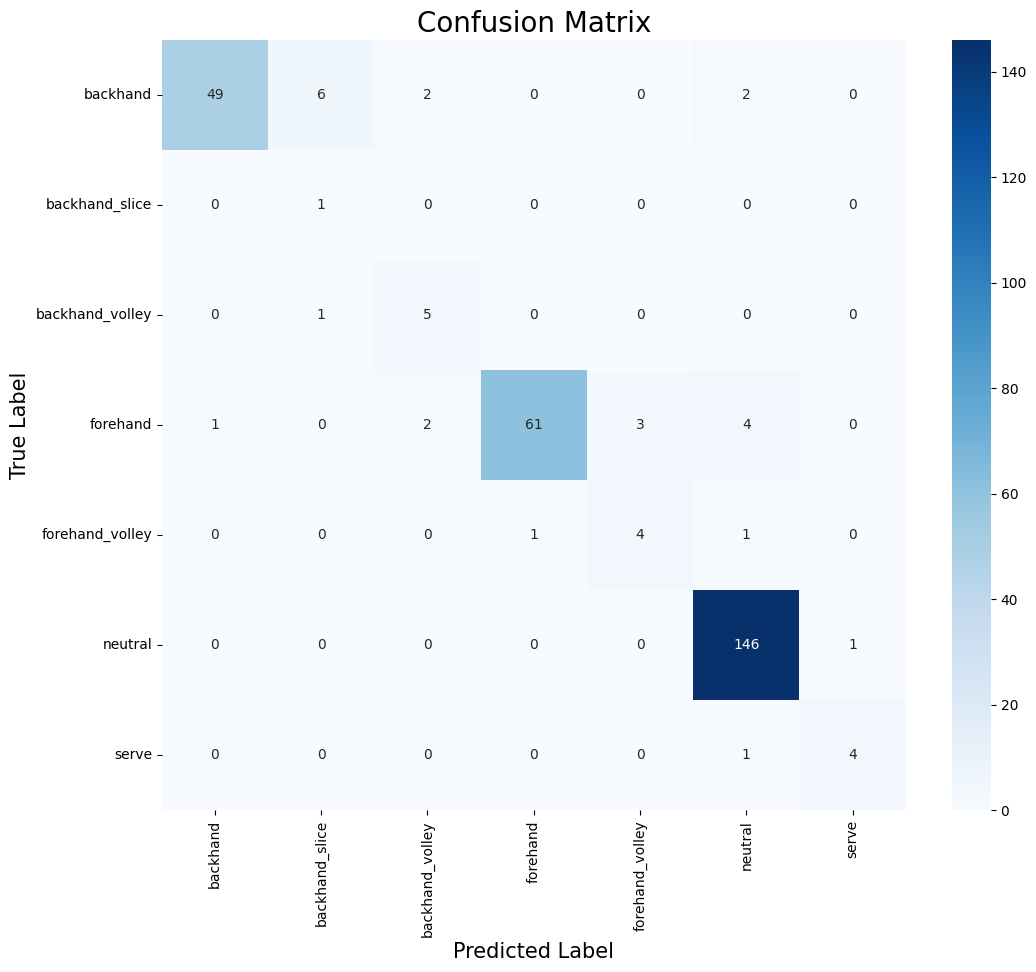

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots a confusion matrix using Seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(12, 10))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)
    plt.show()

# --- Train and Evaluate the Best Model ---

# 1. Select the best model (e.g., based on highest mean accuracy)
best_model_name = summary_df.sort_values(by=f'Mean Accuracy ({N_SPLITS}-Fold CV)', ascending=False).iloc[0]['Model']
print(f"Proceeding with the best model: '{best_model_name}' for final evaluation.")

# 2. Prepare the full dataset for final training
num_classes = len(label_encoder.classes_)
input_shape = X_train_full.shape[1:]
y_train_encoded = label_encoder.transform(y_train_full)
y_train_cat = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

y_test_encoded = label_encoder.transform(y_test)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# 3. Build a new instance of the best model
models = get_models(input_shape, num_classes)
final_model = models[best_model_name]()

# 4. Train on the full training data
print("\nTraining the final model on the entire training dataset...")
class_weights_final = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict_final = dict(enumerate(class_weights_final))

final_model.fit(X_train_full, y_train_cat,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                class_weight=class_weight_dict_final,
                callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
                verbose=1)

# 5. Evaluate on the held-out test set
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = final_model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# 6. Plot the confusion matrix
test_preds = final_model.predict(X_test)
test_pred_classes = np.argmax(test_preds, axis=1)

plot_confusion_matrix(y_test_encoded, test_pred_classes, label_encoder.classes_)

## 7. Qualitative Analysis: Visualizing Predictions

Finally, we can visualize some predictions on the test set to get a qualitative feel for the model's performance. The helper function `to_gif` converts the skeleton data into an animation.

--- Prediction for Sample #152 ---
Ground Truth: neutral
Prediction: neutral (89.93% confidence)

Prediction Probabilities:
  - backhand: 0.09%
  - backhand_slice: 0.01%
  - backhand_volley: 3.94%
  - forehand: 1.09%
  - forehand_volley: 4.21%
  - neutral: 89.93%
  - serve: 0.74%


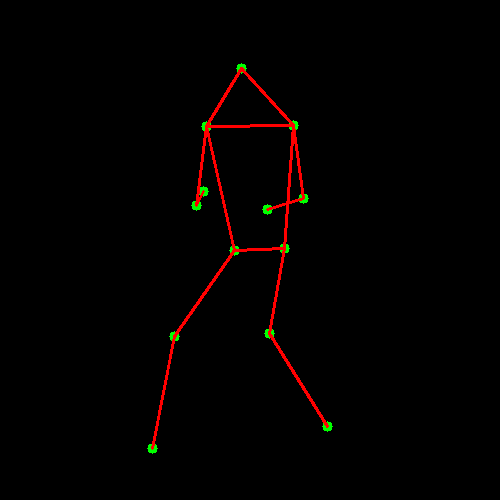

In [10]:
import imageio
import random
from IPython.display import Image, display
import cv2

def to_gif(shot):
    KEYPOINTS = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]
    KEYPOINTS_DICT = {name: i for i, name in enumerate(KEYPOINTS)}
    EDGES = [("nose", "left_shoulder"), ("nose", "right_shoulder"), ("left_shoulder", "left_elbow"), ("left_elbow", "left_wrist"), ("right_shoulder", "right_elbow"), ("right_elbow", "right_wrist"), ("left_shoulder", "right_shoulder"), ("left_shoulder", "left_hip"), ("right_shoulder", "right_hip"), ("left_hip", "right_hip"), ("left_hip", "left_knee"), ("left_knee", "left_ankle"), ("right_hip", "right_knee"), ("right_knee", "right_ankle")]
    height, width = 500, 500
    frames = []
    
    for i in range(len(shot)):
        frame = np.zeros((height, width, 3), np.uint8)
        shot_inst = shot[i, :]
        
        for k in range(len(KEYPOINTS)):
            x, y = int(shot_inst[2*k+1] * width), int(shot_inst[2*k] * height)
            if x > 0 and y > 0: # Only draw visible keypoints
                cv2.circle(frame, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        
        for edge in EDGES:
            p1_idx, p2_idx = KEYPOINTS_DICT[edge[0]], KEYPOINTS_DICT[edge[1]]
            y1, x1 = int(shot_inst[2*p1_idx] * height), int(shot_inst[2*p1_idx+1] * width)
            y2, x2 = int(shot_inst[2*p2_idx] * height), int(shot_inst[2*p2_idx+1] * width)
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                cv2.line(frame, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        frames.append(frame)
        
    return np.array(frames)

def display_prediction(idx):
    # Get the sample
    sample_x = X_test[idx]
    true_label_encoded = y_test_encoded[idx]
    true_label_name = label_encoder.inverse_transform([true_label_encoded])[0]
    
    # Get model prediction
    pred_probs = test_preds[idx]
    pred_label_encoded = np.argmax(pred_probs)
    pred_label_name = label_encoder.inverse_transform([pred_label_encoded])[0]
    
    # Create and display GIF
    gif_path = "animation.gif"
    converted_images = to_gif(sample_x)
    imageio.mimsave(gif_path, converted_images, fps=15)
    
    print(f"--- Prediction for Sample #{idx} ---")
    print(f"Ground Truth: {true_label_name}")
    print(f"Prediction: {pred_label_name} ({pred_probs[pred_label_encoded]:.2%} confidence)")
    
    print("\nPrediction Probabilities:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  - {class_name}: {pred_probs[i]:.2%}")
        
    display(Image(filename=gif_path))

# Display a random prediction
random_idx = random.randint(0, len(X_test) - 1)
display_prediction(random_idx)